## Description
---
Train a deep convolutional network from scratch to recognize scenes

(vs)

Fine-tune a pre-trained deep network. 


In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # normalize img pixels to [-1, 1]
  #
  img = img.astype('float64')
  # Normalizing the image pixels
  tmp_img = 2.*(img - np.min(img))/np.ptp(img)-1
  return tmp_img

# Image augmentation (mirroring, rotating, adding noise)
def img_augment(data,labels, mirror=False, rotate=False, noise=False):
  tmp_len = len(data)
  # Loop over all the images
  for i in range(tmp_len):
    if mirror:
      # Reverse the pixel values
      data.append(data[i][:, ::-1])
      labels.append(labels[i])

    if rotate:
      # A random angle of rotation between 20% on the left and 20% on the right
      random_angle = random.uniform(-20, 20)
      # Rotate the image
      tmp = sk.transform.rotate(data[i], random_angle)
      data.append(tmp)
      labels.append(labels[i])

    if noise:
      # Add some random noise
      data.append(sk.util.random_noise(data[i]))
      labels.append(labels[i])
  # Return the augmented data
  return data, labels

# Noramalize the image (zero centering)
def img_normalize(data):
  tmp_data = np.stack( data, axis=0 )
  # Calculate the mean value
  tmp_batch_mean = np.mean(tmp_data, axis = 0)
  # Calculate the std
  tmp_batch_std = np.std(tmp_data, axis = 0)
  # (pixel value - mean) / std
  data = tmp_data - tmp_batch_mean
  data = data / tmp_batch_std
  return data

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False, aug_list=[True,False,False]):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
            
    #
    # Data Augmentation
    # mirroring
    #
    if augment:
      data, labels = img_augment(data, labels, *aug_list)
      # data, labels = img_augment(data, labels, mirror=True, rotate=True)

    #
    # Data Normalization
    # norm data to zero-centered
    #
    if zero_centered:
      data = img_normalize(data)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'LivingRoom', 1: 'Suburb', 2: 'Mountain', 3: 'InsideCity', 4: 'Store', 5: 'Street', 6: 'Office', 7: 'Kitchen', 8: 'OpenCountry', 9: 'TallBuilding', 10: 'Industrial', 11: 'Bedroom', 12: 'Coast', 13: 'Flower', 14: 'Highway', 15: 'Forest', 16: '_DS_Store'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
# Data without augmentation and zero centering
trainloader_small_plain = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, zero_centered=False, aug_list=[True,False,False]))
# Data with augmentation
trainloader_small_aug = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=False, aug_list=[True,False,False]))
# Data with zero centering
trainloader_small_zero = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, zero_centered=True, aug_list=[True,False,False]))
# Data with augmentation and zero centering
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True, aug_list=[True,False,False]))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
2400
50
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from cl

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Coast


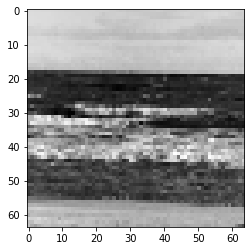

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Training a Network From Scratch:

In [ ]:
# ==========================================
#       Define Network Architecture
# ==========================================
class CNN_base(nn.Module):
    def __init__(self):
        super(CNN_base,self).__init__()
        l1_channels = 8
        l2_channels = 32
        self.seq_model = nn.Sequential(
          # Convolution layer 1 with stride 1 and padding 1
          nn.Conv2d(in_channels=1, out_channels=l1_channels, kernel_size=3, stride=1, padding=1),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Convolution layer 2 with stride 1 and padding 1
          nn.Conv2d(in_channels=l1_channels, out_channels=l2_channels, kernel_size=3, stride=1, padding=1),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear_layers = nn.Sequential(
          # nn.Dropout(p=0.5, inplace=False),
          # Linear layer
          nn.Linear(in_features=l2_channels*16*16, out_features=1000),   #Flattened image is fed into linear NN and reduced to half size
          # RELU Activation
          nn.ReLU(inplace=True),
          # Linear final output layer with 16 output features
          nn.Linear(in_features=1000, out_features=16)      #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
        )
    # Forward pass
    def forward(self, inputs):
      # Getting output from convolution layers
      output1 = self.seq_model(inputs)
      # Reshaping (flattening) to feed into the subsequent linear layers
      output1 = output1.view(output1.size()[0],-1)
      # Getting output from final linear layers
      outputs = self.linear_layers(output1)
      return outputs

class CNN_mod1(nn.Module):
    def __init__(self):
        super(CNN_mod1,self).__init__()
        l1_channels = 8
        l2_channels = 32
        # Convolution layers
        self.seq_model = nn.Sequential(
          # Convolution layer 1 with stride 1 and padding 1
          nn.Conv2d(in_channels=1, out_channels=l1_channels, kernel_size=3, stride=1, padding=1),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Dropout layer
          nn.Dropout2d(p=0.5),
          # Convolution layer 2 with stride 1 and padding 1
          nn.Conv2d(in_channels=l1_channels, out_channels=l2_channels, kernel_size=3, stride=1, padding=1),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear_layers = nn.Sequential(
          # nn.Dropout(p=0.5, inplace=False),
          # Linear layer
          nn.Linear(in_features=l2_channels*16*16, out_features=1000),   #Flattened image is fed into linear NN and reduced to half size
          # RELU Activation
          nn.ReLU(inplace=True),
          # Linear final output layer with 16 output features
          nn.Linear(in_features=1000, out_features=16)      #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
        )
          
    # Forward pass
    def forward(self, inputs):
      # Getting output from convolution layers
      output1 = self.seq_model(inputs)
      # Reshaping (flattening) to feed into the subsequent linear layers
      output1 = output1.view(output1.size()[0],-1)
      # Getting output from final linear layers
      outputs = self.linear_layers(output1)
      return outputs

class CNN_act_fn(nn.Module):
    def __init__(self, activation_layer):
        super(CNN_act_fn,self).__init__()
        l1_channels = 8
        l2_channels = 32
        # Convolution layers
        self.seq_model = nn.Sequential(
          # Convolution layer 1 with stride 1 and padding 1
          nn.Conv2d(in_channels=1, out_channels=l1_channels, kernel_size=3, stride=1, padding=1),
          # RELU Activation
          activation_layer, #nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Dropout layer
          nn.Dropout2d(p=0.5),
          # Convolution layer 2 with stride 1 and padding 1
          nn.Conv2d(in_channels=l1_channels, out_channels=l2_channels, kernel_size=3, stride=1, padding=1),
          # RELU Activation
          activation_layer, #nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear_layers = nn.Sequential(
          # nn.Dropout(p=0.5, inplace=False),
          # Linear layer
          nn.Linear(in_features=l2_channels*16*16, out_features=1000),   #Flattened image is fed into linear NN and reduced to half size
          # RELU Activation
          activation_layer, #nn.ReLU(inplace=True),
          # Linear final output layer with 16 output features
          nn.Linear(in_features=1000, out_features=16)      #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
        )
          
    # Forward pass
    def forward(self, inputs):
      # Getting output from convolution layers
      output1 = self.seq_model(inputs)
      # Reshaping (flattening) to feed into the subsequent linear layers
      output1 = output1.view(output1.size()[0],-1)
      # Getting output from final linear layers
      outputs = self.linear_layers(output1)
      return outputs
    
class CNN_batch_norm(nn.Module):
    def __init__(self):
        super(CNN_batch_norm,self).__init__()
        l1_channels = 8
        l2_channels = 32
        # Convolution layers
        self.seq_model = nn.Sequential(
          # Convolution layer 1 with stride 1 and padding 1
          nn.Conv2d(in_channels=1, out_channels=l1_channels, kernel_size=3, stride=1, padding=1),
          # Batch normalization
          nn.BatchNorm2d(l1_channels),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Dropout layer
          nn.Dropout2d(p=0.5),
          # Convolution layer 2 with stride 1 and padding 1
          nn.Conv2d(in_channels=l1_channels, out_channels=l2_channels, kernel_size=3, stride=1, padding=1),
          # Batch normalization
          nn.BatchNorm2d(l2_channels),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear_layers = nn.Sequential(
          # nn.Dropout(p=0.5, inplace=False),
          # Linear layer
          nn.Linear(in_features=l2_channels*16*16, out_features=1000),   #Flattened image is fed into linear NN and reduced to half size
          # RELU Activation
          nn.ReLU(inplace=True),
          # Linear final output layer with 16 output features
          nn.Linear(in_features=1000, out_features=16)      #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
        )
          
    # Forward pass
    def forward(self, inputs):
      # Getting output from convolution layers
      output1 = self.seq_model(inputs)
      # Reshaping (flattening) to feed into the subsequent linear layers
      output1 = output1.view(output1.size()[0],-1)
      # Getting output from final linear layers
      outputs = self.linear_layers(output1)
      return outputs

class CNN_multi_layer(nn.Module):
    def __init__(self):
        super(CNN_multi_layer,self).__init__()
        l1_channels = 8
        l2_channels = 64
        l3_channels = 64
        l4_channels = 32
        # Convolution layers
        self.seq_model = nn.Sequential(
          # Convolution layer 1 with stride 1 and padding 1
          nn.Conv2d(in_channels=1, out_channels=l1_channels, kernel_size=3, stride=1, padding=1),
          # Batch normalization
          nn.BatchNorm2d(l1_channels),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2),
          
          # # Dropout layer
          # nn.Dropout2d(p=0.5),
          
          # Convolution layer 2 with stride 1 and padding 1
          nn.Conv2d(in_channels=l1_channels, out_channels=l2_channels, kernel_size=5, stride=1, padding=2),
          # Batch normalization
          nn.BatchNorm2d(l2_channels),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2),

          # Convolution layer 2 with stride 1 and padding 1
          nn.Conv2d(in_channels=l2_channels, out_channels=l3_channels, kernel_size=3, stride=1, padding=1),
          # Batch normalization
          nn.BatchNorm2d(l3_channels),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2),

          # Dropout layer
          nn.Dropout2d(p=0.5),

          # Convolution layer 2 with stride 1 and padding 1
          nn.Conv2d(in_channels=l3_channels, out_channels=l4_channels, kernel_size=3, stride=1, padding=1),
          # Batch normalization
          nn.BatchNorm2d(l4_channels),
          # RELU Activation
          nn.ReLU(inplace=True),
          # Pooling
          nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear_layers = nn.Sequential(
          # nn.Dropout(p=0.5, inplace=False),
          # Linear layer
          nn.Linear(in_features=l4_channels*4*4, out_features=1000),   #Flattened image is fed into linear NN and reduced to half size
          # RELU Activation
          nn.ReLU(inplace=True),
          # Linear final output layer with 16 output features
          nn.Linear(in_features=1000, out_features=16)      #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
        )
          
    # Forward pass
    def forward(self, inputs):
      # Getting output from convolution layers
      output1 = self.seq_model(inputs)
      # Reshaping (flattening) to feed into the subsequent linear layers
      output1 = output1.view(output1.size()[0],-1)
      # Getting output from final linear layers
      outputs = self.linear_layers(output1)
      return outputs

In [ ]:
# ==========================================
#         Optimize/Train Network
# ==========================================
def start_train(model, trainloader_small, optimizer, num_epochs=30, train=True):
  debug = True
  # Checking if GPU mode available
  CUDA = torch.cuda.is_available()
  if CUDA:
      model = model.cuda()   
  
  # Using Cross entropy loss function
  loss_func = nn.CrossEntropyLoss()   

  #Define the lists for storing the results
  training_loss = []
  training_accuracy = []
  start = time.time()
  
  # For evaluation, we don't need many epochs, its just running once
  if train==False:
    num_epochs = 1
  # Iterating over epochs - training
  for epoch in range(num_epochs): 
      #Resetting the variables at the begining of every epoch
      correct_pred = 0
      iterations = 0
      iteration_loss = 0.0
      sample_count = 0
      
      # Setting the model into train / eval mode based on the type of execution
      if train:
        model.train()
      else:
        model.eval()
      
      # Iterating over all the training batches
      for i, (inputs, labels) in enumerate(trainloader_small):
          
          # Converting to tensor variable (from pytorch>0.4.0, torch ~ variable)
          inputs = Variable(inputs)
          inputs = inputs.float() 
          # labels = labels - 1
          labels = Variable(labels)
          
          # If we have GPU, shift the data to GPU
          # CUDA = torch.cuda.is_available()
          if CUDA:
              inputs = inputs.cuda()
              labels = labels.cuda()

          # Clearing the gradient
          optimizer.zero_grad()
          # Making a forward pass
          outputs = model.forward(inputs)      

          # Calculating the loss value
          loss_val = loss_func(outputs, labels) 
          # Accumulating the loss 
          iteration_loss += loss_val.data
          if train:
            # Backpropagation
            loss_val.backward()
            # Updating the weights
            optimizer.step()
          
          # Calculating the correct predictions for training data
          _, predicted = torch.max(outputs, 1)
          correct_pred += (predicted == labels).sum()
          sample_count += len(labels)
          iterations += 1

          # Clearing to free up some memory
          del inputs, labels, outputs, predicted
          torch.cuda.empty_cache()

      # Storing the training loss
      training_loss.append(iteration_loss/iterations)
      # Storing the training accuracy
      training_accuracy.append((100 * correct_pred / sample_count))
      if debug:
        if train:
          print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}'
              .format(epoch+1, num_epochs, training_loss[-1], training_accuracy[-1]))
        else:
          print ('Epoch {}/{}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}'
              .format(epoch+1, num_epochs, training_loss[-1], training_accuracy[-1]))
  stop = time.time()
  torch.cuda.empty_cache()
  
  return training_loss[-1], training_accuracy[-1], (stop-start)

In [ ]:
######### Model Training #########
# ==========================================
#            Evaluating Network
# ==========================================

######### To analyze the effect of different techniques on the performance of the model
epoch_count = 30

# Instantiate the model
model = CNN_base()
# Define the optimizer (SGD is used here)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
print("No augmentation and no zero centering:")
inp_data = trainloader_small_plain
# Training
loss, accuracy, time_taken = start_train(model, inp_data, optimizer, num_epochs=epoch_count)
print ('Training Loss: {:.3f}, Training Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))
# Prediction
loss, accuracy, time_taken = start_train(model, testloader_small, optimizer, train = False)
print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))

No augmentation and no zero centering:
Training Loss: 0.909, Training Accuracy: 73.000, Time taken: 16.83550
Test Loss: 1.957, Test Accuracy: 39.000, Time taken: 0.02299


In [ ]:
# Instantiate the model
model = CNN_mod1()
# Choose an optimizer (SGD is used here)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.04)
print("\nBoth augmentation and zero centering, and dropout of 0.5 :")
inp_data = trainloader_small
# Training
loss, accuracy, time_taken = start_train(model, inp_data, optimizer, num_epochs=epoch_count)
print ('Training Loss: {:.3f}, Training Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))
# Prediction
loss, accuracy, time_taken = start_train(model, testloader_small, optimizer, train = False)
print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))


Both augmentation and zero centering, and dropout of 0.5 :
Training Loss: 0.062, Training Accuracy: 98.000, Time taken: 34.00116
Test Loss: 2.526, Test Accuracy: 46.000, Time taken: 0.02294


In [ ]:
# Data augmentation using mirroring, random rotation, random noise addition
trainloader_complete_aug = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True, aug_list=[True,True,True]))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
9600
50


In [ ]:
# Instantiate the model
model = CNN_mod1()
# Choose an optimizer (SGD is used here)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.04)
print("Data augmentation using mirroring, random rotation, random noise addition:")
inp_data = trainloader_complete_aug
# Training
loss, accuracy, time_taken = start_train(model, inp_data, optimizer, num_epochs=epoch_count)
print ('Training Loss: {:.3f}, Training Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))
# Prediction
loss, accuracy, time_taken = start_train(model, testloader_small, optimizer, train = False)
print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))

Data augmentation using mirroring, random rotation, random noise addition:
Training Loss: 0.033, Training Accuracy: 98.000, Time taken: 90.53341
Test Loss: 2.647, Test Accuracy: 48.000, Time taken: 0.02220


In [ ]:
# Batch normalization
# Instantiate the model
model = CNN_batch_norm()
# Choose an optimizer (SGD is used here)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
print("Batch normalization:")
inp_data = trainloader_small
# Training
loss, accuracy, time_taken = start_train(model, inp_data, optimizer, num_epochs=epoch_count)
print ('Training Loss: {:.3f}, Training Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))
# Prediction
loss, accuracy, time_taken = start_train(model, testloader_small, optimizer, train = False)
print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))

Batch normalization:
Training Loss: 0.066, Training Accuracy: 98.000, Time taken: 37.13164
Test Loss: 1.694, Test Accuracy: 51.000, Time taken: 0.02433


In [ ]:
print("Different activation layers:")
for key, value in {"ReLU": nn.ReLU(inplace=True), "Sigmoid": nn.Sigmoid(), "Tanh": nn.Tanh()}.items():
  # Instantiate the model
  model = CNN_act_fn(nn.ReLU(inplace=True))
  # Choose an optimizer (SGD is used here)
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
  print("\n" + key + " activation layer:")
  inp_data = trainloader_small
  # Training
  loss, accuracy, time_taken = start_train(model, inp_data, optimizer, num_epochs=epoch_count)
  print ('Training Loss: {:.3f}, Training Accuracy: {:.3f}, Time taken: {:.5f}'
                .format(loss, accuracy, time_taken))
  # Prediction
  loss, accuracy, time_taken = start_train(model, testloader_small, optimizer, train = False)
  print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'
                .format(loss, accuracy, time_taken))

Different activation layers:

ReLU activation layer:
Training Loss: 0.058, Training Accuracy: 98.000, Time taken: 33.87798
Test Loss: 2.152, Test Accuracy: 51.000, Time taken: 0.02311

Sigmoid activation layer:
Training Loss: 0.071, Training Accuracy: 98.000, Time taken: 33.95397
Test Loss: 2.358, Test Accuracy: 43.000, Time taken: 0.02288

Tanh activation layer:
Training Loss: 0.071, Training Accuracy: 97.000, Time taken: 33.96816
Test Loss: 2.716, Test Accuracy: 44.000, Time taken: 0.02299


In [ ]:
# Modifying architecture
# Instantiate the model
model = CNN_multi_layer()
# Choose an optimizer (SGD is used here)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.04)
print("Changing the arhitecture of the model:")
inp_data = trainloader_small
epoch_count = 40
# Training
loss, accuracy, time_taken = start_train(model, inp_data, optimizer, num_epochs=epoch_count)
print ('Training Loss: {:.3f}, Training Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))
# Prediction
loss, accuracy, time_taken = start_train(model, testloader_small, optimizer, train = False)
print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))

Changing the arhitecture of the model:
Training Loss: 0.085, Training Accuracy: 97.000, Time taken: 67.48110
Test Loss: 1.458, Test Accuracy: 60.000, Time taken: 0.03407


## Fine Tuning a Pre-Trained Deep Network:
Fine tuning Alexnet and performing classification task

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class:

In [ ]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Instantiate the alexnet model
alexnet_model = models.alexnet(pretrained=True)   # Replacing two layers
alexnet_model_l0 = models.alexnet(pretrained=True) # Replacing one layer

# Getting the feature count in the last 2 layers
l1_num_ftrs = alexnet_model.classifier._modules['4'].in_features
l1_out_num_ftrs = 3000
l0_num_ftrs = alexnet_model.classifier._modules['6'].in_features

# Replacing the second linear layer from the last layer with custom layer
alexnet_model.classifier._modules['4'] = nn.Linear(l1_num_ftrs, l1_out_num_ftrs)

# Replacing the last liner layer with custom layer
alexnet_model.classifier._modules['6'] = nn.Linear(l1_out_num_ftrs, 16)
alexnet_model = alexnet_model.to(device)

# Replacing the last liner layer with custom layer (in a different model)
alexnet_model_l0.classifier._modules['6'] = nn.Linear(l0_num_ftrs, 16)
alexnet_model_l0 = alexnet_model_l0.to(device)

print("Replacing last two layers:")
# Defining the optimizer function
optimizer_ft = torch.optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)
# print(alexnet_model)
# Training
loss, accuracy, time_taken = start_train(alexnet_model, trainloader_large, optimizer_ft, num_epochs=30)
print ('Train Loss: {:.3f}, Train Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))
# Prediction
loss, accuracy, time_taken = start_train(alexnet_model, testloader_large, optimizer_ft, train = False)
print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))

print("Replacing last one layer:")
optimizer_ft_l0 = torch.optim.SGD(alexnet_model_l0.parameters(), lr=0.001, momentum=0.9)
# print(alexnet_model_l0)
loss, accuracy, time_taken = start_train(alexnet_model_l0, trainloader_large, optimizer_ft_l0, num_epochs=30)
print ('Train Loss: {:.3f}, Train Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))
loss, accuracy, time_taken = start_train(alexnet_model_l0, testloader_large, optimizer_ft_l0, train = False)
print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'
              .format(loss, accuracy, time_taken))

Replacing last two layers:
Train Loss: 0.012, Train Accuracy: 99.000, Time taken: 149.05260
Test Loss: 1.018, Test Accuracy: 78.000, Time taken: 0.27759
Replacing last one layer:
Train Loss: 0.008, Train Accuracy: 99.000, Time taken: 152.50649
Test Loss: 0.812, Test Accuracy: 84.000, Time taken: 0.28323


Alexnet + SVM classifier:

In [ ]:
import torchvision.models as models
from sklearn import svm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Instantiating the model
alexnet_model_svm = models.alexnet(pretrained=True)
# Selecting the optimizer function (SGD here)
optimizer_ft = torch.optim.SGD(alexnet_model_svm.parameters(), lr=0.001, momentum=0.9)
# Removing the last layer i.e., reading the features from last but one layer
new_classifier = list(alexnet_model_svm.classifier.children())[:-2]
# Updating the classifier model
alexnet_model_svm.classifier =  nn.Sequential(*new_classifier)
alexnet_model_svm = alexnet_model_svm.to(device)

# Function to get features from Alexnet
def get_alexnet_features(alexnet_model_svm, trainloader_large):
  train_X = []
  train_Y = np.array([])
  for i, (inputs, labels) in enumerate(trainloader_large):  
    # Convert to torch Variable
    inputs = Variable(inputs)
    inputs = inputs.float() 
    labels = Variable(labels)
    
    # Check if GPU can be used
    CUDA = torch.cuda.is_available()
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
    # Make the forward pass
    outputs = alexnet_model_svm.forward(inputs)[:,:300]  
    # Accumulate the features (output from Alexnet model is input to SVM)
    train_X = train_X + list(outputs.cpu().data.numpy())
    train_Y = np.concatenate((train_Y, labels.cpu().data.numpy()), axis=0)

  train_X = np.array(train_X)
  # Return the features
  return train_X, train_Y

start = time.time()
# Get the train feature data for SVM classifier
train_X, train_Y = get_alexnet_features(alexnet_model_svm, trainloader_large)
# Get the test feature data
test_X, test_Y = get_alexnet_features(alexnet_model_svm, testloader_large)


# Instantiate the SVM classifier
model_svc = svm.LinearSVC(C=0.00103, max_iter=5000)
# Train the SVM classifier
accuracy = model_svc.fit(train_X, train_Y).score(train_X, train_Y) * 100
time_taken = time.time()-start
print ('Train Accuracy: {:.3f}, Time taken: {:.5f}'.format(accuracy, time_taken))

start = time.time()
# Make predictions
pred_labels = model_svc.predict(test_X)

time_taken = time.time()-start
# Find the count of correct labels
correct = (pred_labels == test_Y).sum()

# Calculate the accuracy
accuracy = float(correct) / len(test_Y) * 100
print ('Test Accuracy: {:.3f}, Time taken: {:.5f}'.format(accuracy, time_taken))

Train Accuracy: 97.250, Time taken: 4.30311
Test Accuracy: 75.750, Time taken: 0.00140


VGG + SVM classifier 

In [ ]:
def start_test_vgg(model, trainloader_small, optimizer, num_epochs=30, train=True):
  debug = False 
  
  # Using Cross entropy loss function
  loss_func = nn.CrossEntropyLoss()   

  # Define the lists for storing the results
  training_loss = []
  training_accuracy = []
  start = time.time()
  
  # For evaluation, we don't need many epochs, its just running once
  if train==False:
    num_epochs = 1
  # Iterating over epochs - training
  for epoch in range(num_epochs): 
      #Resetting the variables at the begining of every epoch
      correct_pred = 0
      iterations = 0
      iteration_loss = 0.0
      sample_count = 0
      
      # Setting the model into train / eval mode based on the type of execution
      if train:
        model.train()
      else:
        model.eval()
      with torch.no_grad():
        # Iterating over all the training batches
        for (inputs, labels) in trainloader_small[0:1]:
            
            # Converting to tensor variable (from pytorch>0.4.0, torch ~ variable)
            inputs = Variable(inputs)
            inputs = inputs.float() 
            # labels = labels - 1
            labels = Variable(labels)
            
            # If we have GPU, shift the data to GPU
            CUDA = torch.cuda.is_available()
            if CUDA:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Clearing the gradient
            optimizer.zero_grad()
            # Making a forward pass
            outputs = model.forward(inputs)      

            # Calculating the loss value
            loss_val = loss_func(outputs, labels) 
            # Accumulating the loss 
            iteration_loss += loss_val.data
            if train:
              # Backpropagation
              loss_val.backward()
              # Updating the weights
              optimizer.step()
            
            # Calculating the correct predictions for training data
            _, predicted = torch.max(outputs, 1)
            correct_pred += (predicted == labels).sum()
            sample_count += len(labels)
            iterations += 1

            # Clearing to free up some memory
            del inputs, labels, outputs, predicted
            torch.cuda.empty_cache()

      # Storing the training loss
      training_loss.append(iteration_loss/iterations)
      # Storing the training accuracy
      training_accuracy.append((100 * correct_pred / sample_count))
      if debug:
        if train:
          print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}'
              .format(epoch+1, num_epochs, training_loss[-1], training_accuracy[-1]))
        else:
          print ('Epoch {}/{}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}'
              .format(epoch+1, num_epochs, training_loss[-1], training_accuracy[-1]))
  stop = time.time()
  torch.cuda.empty_cache()
  
  return training_loss[-1], training_accuracy[-1], (stop-start)

In [ ]:
######### VGG #########

import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_vgg16 = models.vgg16_bn(pretrained=True)

# print(model_vgg16)

# Getting the feature count in the last 2 layers
l0_num_ftrs = model_vgg16.classifier._modules['6'].in_features

# Replacing the last liner layer with custom layer
model_vgg16.classifier._modules['6'] = nn.Linear(l0_num_ftrs, 16)
model_vgg16 = model_vgg16.to(device)

optimizer_func = torch.optim.SGD(model_vgg16.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Train Vgg

loss, accuracy, time_taken = start_train(model_vgg16, trainloader_large, optimizer_func, num_epochs=10)
print ('Train Loss: {:.3f}, Train Accuracy: {:.3f}, Time taken: {:.5f}'.format(loss, accuracy, time_taken))

# Saving the model for easy testing
# torch.save(model_vgg16.state_dict(), save_path)

Epoch 1/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 2/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 3/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 4/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 5/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 6/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 7/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 8/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 9/10, Training Loss: 0.000, Training Accuracy: 100.000
Epoch 10/10, Training Loss: 0.000, Training Accuracy: 100.000
Train Loss: 0.000, Train Accuracy: 100.000, Time taken: 1136.56317


In [ ]:
# Test Vgg

# model_vgg16.load_state_dict(torch.load(save_path))
loss, accuracy, time_taken = start_test_vgg(model_vgg16, testloader_large, optimizer_func, train=False)
print ('Test Loss: {:.3f}, Test Accuracy: {:.3f}, Time taken: {:.5f}'.format(loss, accuracy, time_taken))

Test Loss: 0.084, Test Accuracy: 96.000, Time taken: 0.89257
